In [ ]:
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 3.4 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
import numpy as np
from numpy.random import default_rng
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from collections import namedtuple
#DQN package
#!pip install torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Quantitative Trading2.xls to Quantitative Trading2.xls


# Helper Functions

In [ ]:
class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size, typedqn = 'Dqn'):
        
        super().__init__()
        self.typedqn = typedqn
        self.fc1 = nn.Linear(input_size, size_hidden)
        self.bn1 = nn.BatchNorm1d(size_hidden)
        
        self.fc2 = nn.Linear(size_hidden, size_hidden)   
        self.bn2 = nn.BatchNorm1d(size_hidden)

        self.fc3 = nn.Linear(size_hidden, size_hidden)  
        self.bn3 = nn.BatchNorm1d(size_hidden)
        
        if self.typedqn == 'Duelling':
            print('Duelling Activated')
            self.Value = nn.Linear(size_hidden, 1)
            self.Advantage = nn.Linear(size_hidden, output_size)
        if typedqn == 'Dqn':
            print('Dqn')
            self.fc4 = nn.Linear(size_hidden, output_size)
        
        
    def forward(self, x):
        h1 = F.relu(self.bn1(self.fc1(x.float())))
        h2 = F.relu(self.bn2(self.fc2(h1)))
        h3 = F.relu(self.bn3(self.fc3(h2)))
       
        if self.typedqn == 'Dqn':
            output = self.fc4(h3.view(h3.size(0), -1))
            return output
        
        if self.typedqn == 'Duelling':
                
            value = self.Value(h3.view(h3.size(0), -1))
            advantage = self.Advantage(h3.view(h3.size(0), -1))
            
            return value + advantage - advantage.mean()
            

In [ ]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random.random() > self.epsilon
        
        if is_greedy :
            # we select greedy action
            with torch.no_grad():
                Q_network.eval()
                # index of the maximum over dimension 1.
                index_action = Q_network(state).max(1)[1].view(1, 1).cpu()[0][0].item()
                Q_network.train()
        else:
            # we sample a random action
            index_action = random.randint(0,2) # will randomely choose a number within [0,1,2] aka [buy, sell, hold] 
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start

In [ ]:
class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    #just add to memory state,action, state+1,reward in a tensor 
    def push(self, state, action, next_state, reward):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
            
        action_tensor = torch.tensor([action], device=device).unsqueeze(0)

        reward = torch.tensor([reward], device=device).unsqueeze(0)/10. # reward scaling

        self.memory[self.position] = Transition(state, action_tensor, next_state, reward)
        self.position = (self.position + 1) % self.capacity
    
    #might need changing
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
def optimize_model(doubledqn = False):
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)

    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q values using policy net 
    Q_values = Q_network(state_batch).gather(1, action_batch)

    # Compute next Q values using Q_targets
    next_Q_values = torch.zeros( BATCH_SIZE, device=device)
    if doubledqn == False : 
      # Compute next Q values using Q_targets
      next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
      next_Q_values = next_Q_values.unsqueeze(1)
    else:

      Qaction = Q_network(non_final_next_states).max(1)[1].detach()
      next_Q_values = Q_target(non_final_next_states)[Qaction].unsqueeze(1)
      #ComputeTarget  
    target_Q_values = (next_Q_values * GAMMA) + reward_batch
    loss = F.mse_loss(Q_values, target_Q_values) 
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()


    
    return loss

# Environment 

### define class

In [ ]:
class StockTradingEnv:
    """
        Specifying the action and observation componenets that would help the agent to learn and move though the environment
        
    """
    def __init__(self,
               fee=0.1,
               starting_date="2015-01-24",
               max_training_date = '2020-12-31',
               inital_cash_balance = 50000,
               initial_number_shares = 10):
        
        # Defining the parameters specific to the environment
        self.df = pd.read_excel("Quantitative Trading2.xls", sheet_name='SPY (1)')
        self.action_list = ['Buy','Sell','Hold']
        self.feature_list = ['Daily Close Returns ', 'Open','High','Low', 'WR(6)', 'WR(12)', 'RSI(14)']
        self.feature_list_normalisation = ['Open','High','Low']
        self.normalizefeature = 'Close'
        #setup
        self.fee = fee #Stock trading commission fee per trade
        self.start_date = starting_date
        self.current_step = 0
        self.eventlog = [] #eventlog to keep track 
        self.max_training_date = max_training_date

        #used to calculate portfoliovalue
        self.initial_number_shares = initial_number_shares
        self.inital_cash_balance = inital_cash_balance
        self.cash_balance = inital_cash_balance
        self.number_shares = initial_number_shares
        self.inventory =[]
        
        #Preprocessing
        self.df = self.df[self.df['Date']>=datetime.strptime(self.start_date, '%Y-%m-%d')].reset_index(drop = True)

        self.training_data = self.df[self.df['Date']<datetime.strptime(self.max_training_date, '%Y-%m-%d')]
        for f in self.feature_list_normalisation:
          self.training_data[f] = self.training_data[f]/self.training_data[self.normalizefeature]
        
        self.start_date = self.df['Date'].min()
        self.start_price = self.df[self.df['Date']==self.start_date]['Close'].values[0]


        self.initial_value = self.cash_balance + self.number_shares* self.start_price # define initial stock price
        self.wallet = [self.initial_value]
        self.inventory = [self.start_price]*self.number_shares
        
        #self.training_data,self.observations, self.states, self.transition_matrix, self.reward_matrix = self.qlearning_preprocessing()
        #data preprocessing
        
    def get_state(self,step):
      analytic = np.array(self.training_data[self.feature_list].iloc[step])
      portfolio = np.array([self.number_shares,self.cash_balance])
      state_tensor = np.concatenate((analytic,portfolio))
      state_tensor = torch.tensor(state_tensor, device=device).unsqueeze(0)  
      return state_tensor   

    
    def step(self,action):
        """
        Move the step and recalculate portfolio Value 
        """
        
        #Check the line below
        current_price = self.df.iloc[self.current_step]['Close']
        reward = 0 
        ## Add condition if buy but enough cash -> hold (bump example) and similarly if sell but no more share -> hold
        if action == 'Buy':
            if current_price < self.cash_balance:
              self.number_shares +=1
              self.cash_balance = self.cash_balance -self.fee - current_price
              self.wallet.append(self.cash_balance + self.number_shares* current_price)
              self.inventory.append(current_price)
            
        if action == 'Sell':
            if self.number_shares >0 :
                self.number_shares -=1
                self.cash_balance = self.cash_balance -self.fee + current_price
                self.wallet.append(self.cash_balance + self.number_shares* current_price)
                bought_price = self.inventory.pop(0)
                reward = max(((current_price - bought_price )/bought_price), 0)
    
            #penalty to sell when no position held 
            else:
               reward = -0.001

        
        if action == 'Hold': 
            self.wallet.append(self.cash_balance + self.number_shares* current_price)


        
        #create pandas or array of array which will include = step, action, state, wallet value, reward.     
        self.eventlog.append([self.current_step, self.number_shares,self.cash_balance,current_price,action])
        self.current_step+=1
        next_state = self.get_state(self.current_step)
        return next_state, reward
        
    def display(self):
        print ('Portfolio contains :' + str(self.number_shares ))
        print ('Initial Portfolio Value was : '+ str(self.initial_value))
        print (self.wallet)

        print ('inventory')
        print(*self.inventory, sep = ", ") 

    def reset(self):
        self.current_step = 0
        self.cash_balance = self.inital_cash_balance
        self.number_shares = self.initial_number_shares
        self.inventory =[self.start_price]*self.number_shares
        self.eventlog = []

### set up enviroment

In [ ]:
trading = StockTradingEnv(starting_date="2015-01-24",max_training_date = '2020-12-31')

In [ ]:
trading.display()

Portfolio contains :10
Initial Portfolio Value was : 52054.49997
[52054.49997]
inventory
205.449997, 205.449997, 205.449997, 205.449997, 205.449997, 205.449997, 205.449997, 205.449997, 205.449997, 205.449997


In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
policy = E_Greedy_Policy(0.99, decay=0.997, min_epsilon=0.001)

OBS_SIZE = len(trading.feature_list)+2
HIDDEN_SIZE = 6  # mean of the output/input layer
ACTION_SIZE = 3
num_episodes = 1000
memory = ReplayMemory(250)#increase memory to try to avoid sampling from the same data and overfitting to test 
policy.reset()
BATCH_SIZE = 32
GAMMA = 0.7 # preference for long term reward
rewards_history = []
loss_history = []

doubledqn = True
duelingdqn = False

if duelingdqn == True:
  typeddqn = 'Duelling'
else:
  typeddqn = 'Dqn'

Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE,typedqn = typeddqn).to(device)
Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE,typedqn = typeddqn).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

TARGET_UPDATE = 10
optimizer = optim.SGD(Q_network.parameters(), lr=0.01)


Dqn
Dqn


In [54]:


#number of episode
for i_episode in range(num_episodes):
    state = trading.reset()
    total_reward = 0
    
    #per episode - fill the memory with every state,i.e every day in our period
    for i in  range(0,len(trading.training_data.index)-2) :

        
        # Get action and act in the world. Dirty way improve coding
        state_tensor= trading.get_state(trading.current_step)
        action = policy(state_tensor)
        action_name = trading.action_list[action]

        next_state, reward = trading.step(action_name)
        

        total_reward += float(reward)

        # Store the transition in memory
        memory.push(state_tensor, action, next_state, float(reward))
        #BATCH_SIZE = min(BATCH_SIZE_initial,len(memory.memory))
        # Perform one step of the optimization
        if len(memory.memory)>BATCH_SIZE:
            started_training = True
            l = optimize_model(doubledqn)


    policy.update_epsilon()
    rewards_history.append( float(total_reward) )
    loss_history.append(l.detach().cpu())


 

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:

        Q_target.load_state_dict(Q_network.state_dict())
    
    if (i_episode) % 10 == 0:
        
        print('Episode ', i_episode, ': ', 'reward :',  total_reward, 'eps: ', 
              policy.epsilon, ' loss:', l.detach().cpu())   
        print( sum(rewards_history[-10:])/10)    

print('Complete')




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([32, 32, 3])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode  0 :  reward : 18.682230801983106 eps:  0.98703  loss: tensor(7499.2109)
1.8682230801983106
Episode  10 :  reward : 10.091921488931657 eps:  0.9578156659018894  loss: tensor(0.0991)
13.397120696176213
Episode  20 :  reward : 7.071260993511062 eps:  0.9294660241807036  loss: tensor(0.0084)
11.083428154234767
Episode  30 :  reward : 6.221215631630003 eps:  0.9019554814785994  loss: tensor(0.0004)
8.59070968308818
Episode  40 :  reward : 10.582734708756336 eps:  0.8752592019556485  loss: tensor(0.0358)
12.208835442757803
Episode  50 :  reward : 16.168952544366377 eps:  0.8493530848686524  loss: tensor(0.0008)
12.708342001112147
Episode  60 :  reward : 13.176216999025836 eps:  0.8242137428135844  loss: tensor(0.0296)
11.352757274181558
Episode  70 :  reward : 3.2878783001867764 eps:  0.79981848061202  loss: tensor(0.0267)
11.931924656405283
Episode  80 :  reward : 9.209856978745416 eps:  0.776145274822487  loss: tensor(0.0005)
9.92221068030933
Episode  90 :  reward : 2.732317900087

In [56]:
if doubledqn == False and duelingdqn == False:
  totalrewardqn =rewards_history
  totallossdqn = loss_history
if doubledqn == False and duelingdqn == True:
  totalrewardueldqn =rewards_history
  totallossduelqn = loss_history
if doubledqn == True and duelingdqn == False:
  totalrewarddqn =rewards_history
  totallossddqn = loss_history
if doubledqn == True and duelingdqn == False:
  totalrewardddqn =rewards_history
  totallossdddqn = loss_history

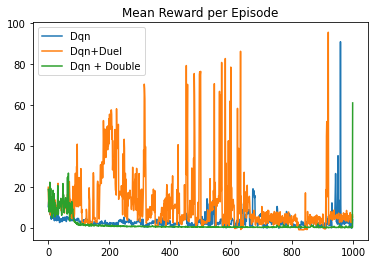

In [58]:
plt.plot( totalrewardqn, label = 'Dqn')   
plt.plot( totalrewardueldqn, label = 'Dqn+Duel')   
plt.plot( totalrewarddqn, label = 'Dqn + Double')   
totalrewarddqn
plt.title('Mean Reward per Episode')
plt.legend()
plt.show()


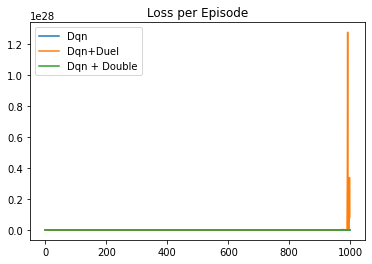

In [59]:
plt.plot( totallossdqn, label = 'Dqn')   
plt.plot( totallossduelqn, label = 'Dqn+Duel')   
plt.plot( totalrewarddqn, label = 'Dqn + Double')   
totalrewarddqn
plt.title('Loss per Episode')
plt.legend()
plt.show()

In [ ]:
policy.epsilon

0.98703